In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

import cv2

# OpenCV Haar Cascades Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class OpenCvDetector(Detector):
    def __init__(self):
        self.detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')
    
    def detect(self, image):
        boxes, confidence = self.detector.detectMultiScale2(
            image, 
            scaleFactor=1.1, 
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE)

        return boxes, confidence
    
opencv = OpenCvDetector()

In [4]:
with TsvHandle('opencv') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = opencv,
        cv2_filter = cv2.COLOR_RGB2BGR,
        use_width_height = True
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [3226/3226]
./results/opencv-20220612-105053.tsv
./results/opencv-20220612-105053-ap.tsv
./results/opencv-20220612-105053-load.tsv
./results/opencv-20220612-105053-metadata.tsv


In [5]:
with TsvHandle('opencv_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = opencv,
        cv2_filter = cv2.COLOR_RGB2BGR,
        use_width_height = True,
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [3226/3226]
./results/opencv_filtered-20220612-105632.tsv
./results/opencv_filtered-20220612-105632-ap.tsv
./results/opencv_filtered-20220612-105632-load.tsv
./results/opencv_filtered-20220612-105632-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-12 10:50:53.849201,0.4,6045978624
1,2022-06-12 10:51:04.914201,44.8,5492658176
2,2022-06-12 10:51:16.019701,49.7,5499215872
3,2022-06-12 10:51:27.061701,43.8,5505474560
4,2022-06-12 10:51:38.123704,45.2,5497716736
5,2022-06-12 10:51:49.161701,50.6,5516869632
6,2022-06-12 10:52:00.197701,50.6,5531455488
7,2022-06-12 10:52:11.213202,48.5,5513326592
8,2022-06-12 10:52:22.372201,51.4,5394227200
9,2022-06-12 10:52:33.552201,49.1,5372719104


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

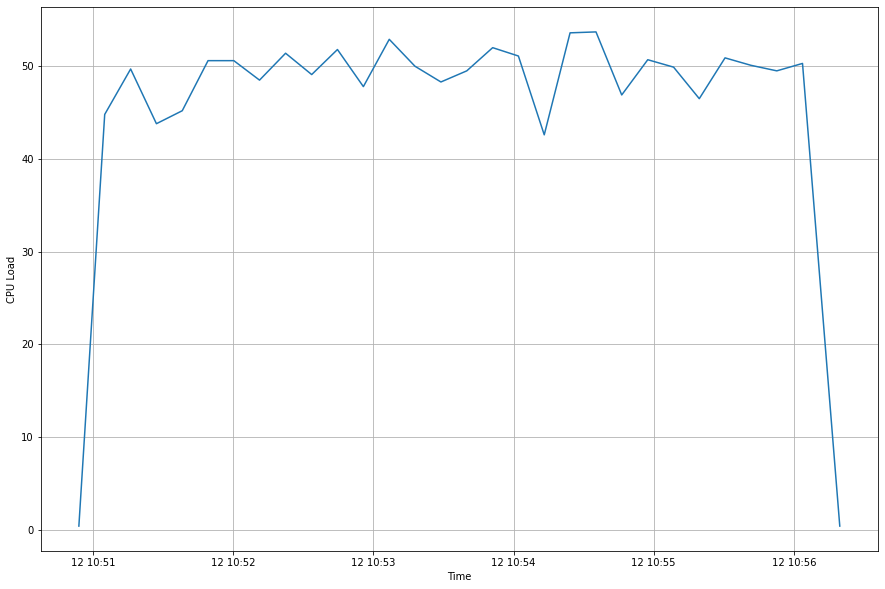

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

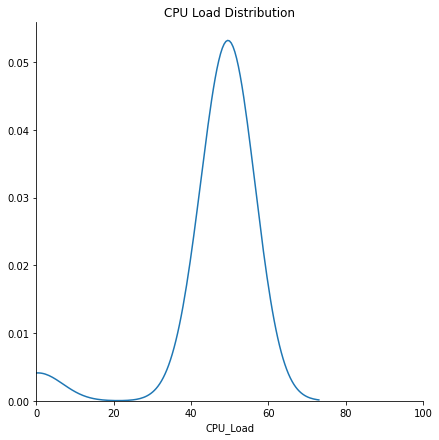

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

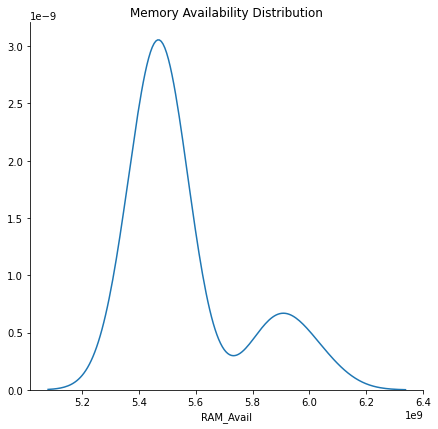

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-12 10:50:54.505701,223104000,0.750000,0.375000,0.500000,"[0.6699566160520607, 0.7114774889029803, 0.044...",3,1,5,8,"[(770.0, 196.0, 857.0, 283.0), (298.0, 156.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-12 10:50:54.582701,71484900,0.000000,0.000000,0.000000,[0.0],0,1,1,1,"[(417.0, 714.0, 737.0, 1034.0)]","[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-06-12 10:50:54.663701,74386000,0.333333,0.500000,0.400000,"[0.0, 0.6550373798504806, 0.0]",1,2,1,2,"[(812.0, 104.0, 866.0, 158.0), (449.0, 40.0, 5...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-06-12 10:50:54.820701,76841600,0.000000,0.000000,0.000000,[],0,0,62,62,[],"[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-06-12 10:50:54.896701,57879400,0.833333,0.625000,0.714286,"[0.6420729029424681, 0.07943482963764197, 0.62...",5,1,3,8,"[(720.0, 63.0, 767.0, 110.0), (172.0, 6.0, 344...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-06-12 10:56:09.274201,133965300,1.000000,1.000000,1.000000,[0.6655021834061136],1,0,0,1,"[(460.0, 153.0, 622.0, 315.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-06-12 10:56:09.419701,137927100,1.000000,0.500000,0.666667,[0.6259521218715995],1,0,1,2,"[(690.0, 412.0, 808.0, 530.0)]","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-06-12 10:56:09.563701,81842700,1.000000,0.740741,0.851064,"[0.65625, 0.4759071980963712, 0.74074074074074...",20,0,7,27,"[(541.0, 379.0, 581.0, 419.0), (573.0, 319.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-06-12 10:56:09.623201,46059500,0.000000,0.000000,0.000000,[0.0],0,1,7,7,"[(290.0, 199.0, 393.0, 302.0)]","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,7.613863e+07,0.462434,0.382268,0.366843,1.657161,0.726906,10.651581,12.308741
std,3.073409e+07,0.434958,0.422531,0.381841,3.204494,1.049534,39.562837,39.822258
min,1.804120e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.606060e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.100330e+07,0.500000,0.171303,0.285714,1.000000,0.000000,2.000000,3.000000
75%,8.831925e+07,1.000000,1.000000,0.666667,2.000000,1.000000,7.000000,9.000000
max,4.519857e+08,1.000000,1.000000,1.000000,37.000000,8.000000,709.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count    3226.000000
mean       76.138667
std        30.734136
min        18.040000
25%        56.060000
50%        71.000000
75%        88.317500
max       451.990000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,167,True,True,False,1.000000,0.000025,1.000000,0.000025,0.000000,0.000000
1,163,True,True,False,1.000000,0.000050,1.000000,0.000050,0.000000,0.000000
2,157,True,True,False,1.000000,0.000076,1.000000,0.000076,0.000000,0.000000
3,155,True,True,True,1.000000,0.000101,1.000000,0.000101,0.250000,0.000025
4,150,True,True,True,1.000000,0.000126,1.000000,0.000126,0.400000,0.000050
...,...,...,...,...,...,...,...,...,...,...
7686,6,False,False,False,0.697932,0.135111,0.664889,0.128715,0.135944,0.026317
7687,6,False,False,False,0.697841,0.135111,0.664802,0.128715,0.135926,0.026317
7688,6,False,False,False,0.697750,0.135111,0.664716,0.128715,0.135908,0.026317
7689,6,False,False,False,0.697659,0.135111,0.664629,0.128715,0.135891,0.026317


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,167,True,True,False,1.000000,0.000140,1.000000,0.000140,0.000000,0.000000
1,163,True,True,False,1.000000,0.000281,1.000000,0.000281,0.000000,0.000000
2,157,True,True,False,1.000000,0.000421,1.000000,0.000421,0.000000,0.000000
3,155,True,True,True,1.000000,0.000561,1.000000,0.000561,0.250000,0.000140
4,150,True,True,True,1.000000,0.000702,1.000000,0.000702,0.400000,0.000281
...,...,...,...,...,...,...,...,...,...,...
4979,6,False,False,False,0.706225,0.493683,0.680924,0.475997,0.163253,0.114121
4980,6,False,False,False,0.706083,0.493683,0.680787,0.475997,0.163220,0.114121
4981,6,True,True,False,0.706142,0.493824,0.680851,0.476137,0.163187,0.114121
4982,6,False,False,False,0.706000,0.493824,0.680714,0.476137,0.163155,0.114121


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

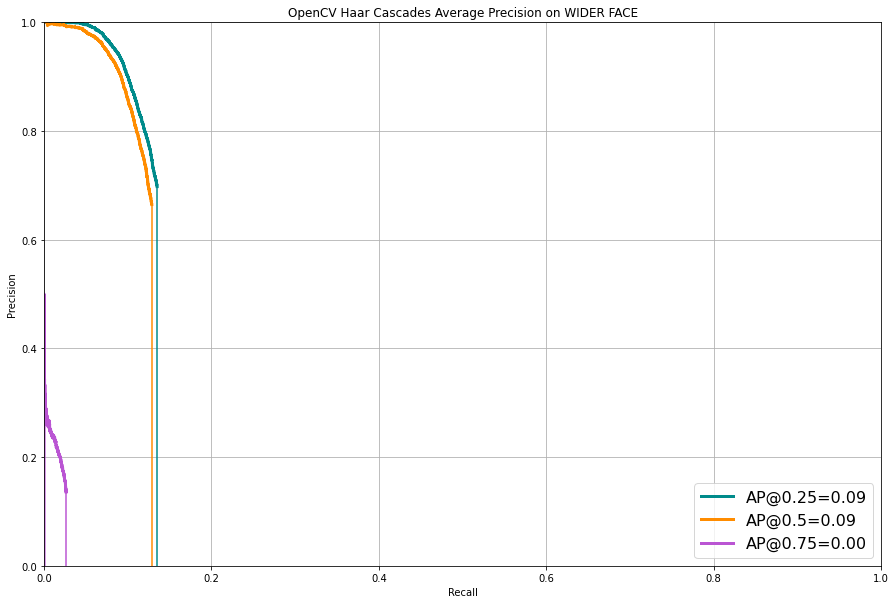

In [19]:
plot_pr(df_ap, 'OpenCV Haar Cascades Average Precision on WIDER FACE')

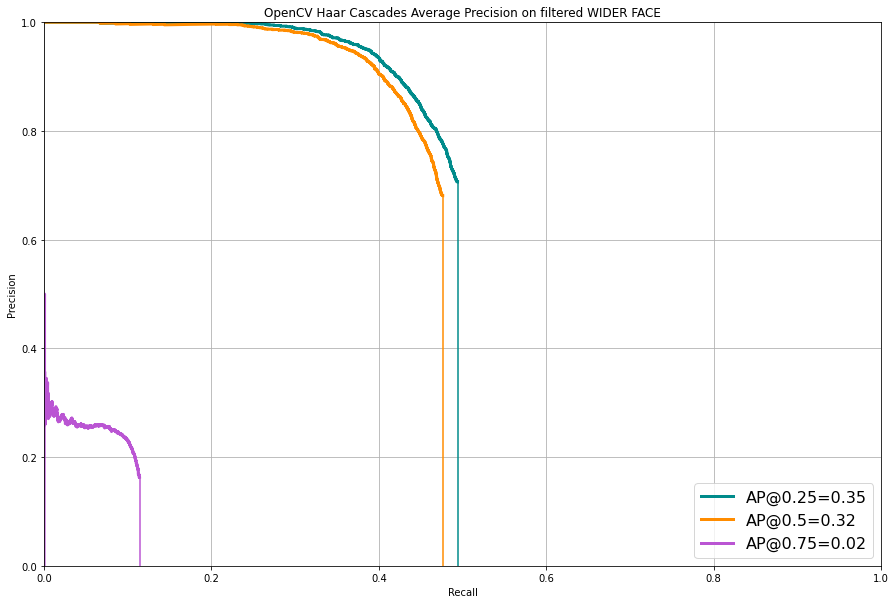

In [20]:
plot_pr(df_ap_filtered, 'OpenCV Haar Cascades Average Precision on filtered WIDER FACE')

# OpenCV Haar Cascades Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class OpenCvDetector(Detector):
    def __init__(self):
        self.detector = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')
    
    def detect(self, image):
        boxes, confidence = self.detector.detectMultiScale2(
            image, 
            scaleFactor=1.1, 
            minNeighbors=5,
            minSize=(30, 30),
            flags=cv2.CASCADE_SCALE_IMAGE)

        return boxes, confidence

opencv = OpenCvDetector()

In [24]:
stt_aps, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=opencv,
    results_folder="opencv",
    save_videos=True,
    cv2_filter = cv2.COLOR_RGB2BGR,
    use_width_height = True
)

Frames: [====================] 100% [164/164], Videos: [216/216]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.62
Mean confidence of boxes in all videos: 46.10
Mean inference time for all frames: 25.23ms
